# Finetune MobileNet_V2

Here import required libraries to run inference on required model

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1
Torchvision Version:  0.14.1


# Dataset loading
Here the data is loaded in data_dir by providing the path of available data set.In this case i have used Spets dataset.This datset consist on  23 classes.

# Model
Here i have used pretrained MObileNet_V2 Model. 

The line model.classifier = nn.Linear(1280, num_classes) updates the final linear layer of the model.

In [2]:
data_dir = "/media/abdul/8266fdc5-61f6-47d6-9e82-aa0e56f4b319/Ilyas/classification/pets_classification/Pet_Breeds"
num_classes = 23
batch_size = 32
num_epochs = 10
model = models.mobilenet_v2(pretrained=True)
# Update model output size to 2.
model.classifier = nn.Linear(1280, num_classes)
model

/home/abdul/miniconda3/envs/detr/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abdul/miniconda3/envs/detr/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

This below code defines two functions in PyTorch: train_model and set_parameter_requires_grad.

The 'train_model' function trains a given PyTorch model on a given dataset, using the specified loss criterion and optimizer.

The 'set_parameter_requires_grad' function is used to set whether the gradients with respect to the parameters of the model should be computed during backpropagation. 

This can be used for "fine-tuning" a pre-trained model, where we want to fine-tune only a few layers, while keeping the rest of the layers frozen.

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
       # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Preprocessing of the dataset
Initialized the data transforms for the train and validation datasets. The data transforms are composed of several operations such as resizing the images to a fixed size.

Created two datasets for train and validation, each using the ImageFolder method from the torchvision datasets class, passing the respective data transform to each.

Created two data loaders for the train and validation datasets using the torch.utils.data.DataLoader method.

I have used the torch.device method to determine the device to run the model on, either a GPU (if available) or the CPU


In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



Initializing Datasets and Dataloaders...


In [5]:
train_dataset_size = len(image_datasets['train'])
val_dataset_size = len(image_datasets['val'])

print("Number of training samples: ", train_dataset_size)
print("Number of validation samples: ", val_dataset_size)

Number of training samples:  3766
Number of validation samples:  115


freeze all of the layers in the model except for layers 17 and 18 in the "features" module and the "classifier" module


In [7]:
model_ft = model.to(device)

params_to_update = []

for name, param in model_ft.named_parameters():
    param.requires_grad == False
    

for name,param in model_ft.named_parameters():

    if 'features.17' in name:
        param.requires_grad == True
        params_to_update.append(param)        

    if 'features.18' in name:
        param.requires_grad == True
        params_to_update.append(param)
        
    if 'classifier' in name:
        param.requires_grad == True
        params_to_update.append(param)
        

# Training of the Model
 Here the train_model function trains the model for 25 epochs and returns the trained model and training history.
 The optimizer used is SGD with a learning rate of 0.0005 and momentum of 0.9.

In [8]:
optimizer_ft = optim.SGD(params_to_update, lr=0.0005, momentum=0.9)

criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, 
                             dataloaders_dict, 
                             criterion, 
                             optimizer_ft, 
                             num_epochs=25)

----------
train Loss: 2.3292 Acc: 0.4740
val Loss: 1.3760 Acc: 0.8087

----------
train Loss: 1.1944 Acc: 0.8059
val Loss: 0.8150 Acc: 0.8957

----------
train Loss: 0.8142 Acc: 0.8486
val Loss: 0.6108 Acc: 0.8957

----------
train Loss: 0.6633 Acc: 0.8667
val Loss: 0.5217 Acc: 0.9043

----------
train Loss: 0.5700 Acc: 0.8725
val Loss: 0.4564 Acc: 0.9043

----------
train Loss: 0.5111 Acc: 0.8842
val Loss: 0.4229 Acc: 0.9217

----------
train Loss: 0.4714 Acc: 0.8954
val Loss: 0.3951 Acc: 0.9130

----------
train Loss: 0.4315 Acc: 0.8975
val Loss: 0.3740 Acc: 0.9217

----------
train Loss: 0.4049 Acc: 0.9044
val Loss: 0.3724 Acc: 0.9130

----------
train Loss: 0.3907 Acc: 0.9057
val Loss: 0.3520 Acc: 0.9217

----------
train Loss: 0.3591 Acc: 0.9182
val Loss: 0.3446 Acc: 0.9304

----------
train Loss: 0.3489 Acc: 0.9161
val Loss: 0.3355 Acc: 0.9391

----------
train Loss: 0.3248 Acc: 0.9190
val Loss: 0.3313 Acc: 0.9304

----------
train Loss: 0.3153 Acc: 0.9296
val Loss: 0.3361 Acc: 

# Evaluation
Here the test data is loaded using the torchvision.datasets.ImageFolder function, which reads the image data from the specified directory, which is data_dir + '/val'.

In [9]:
img_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_data = torchvision.datasets.ImageFolder(data_dir + '/val',transform=img_test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          shuffle=False, num_workers=4)

This code is checking the accuracy of a pre-trained model on a test set.
The predictions are then compared with the actual labels, and the number of correctly predicted labels is summed up and stored in the variable correct. Finally, the accuracy of the model is calculated by dividing correct by total (the total number of test images), and the result is printed.

In [10]:
model_ft.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
       
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
       # print("input",labels)
       # print("output",predicted)
        
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))
    print('correct: {:d}  total: {:d}'.format(correct, total))


Test Accuracy of the model: 93.91304347826087 %
correct: 108  total: 115


# Testing 
Here i Have tested the model prediction on provided data in directory which contain few images of different class

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

classes = ['abyssinian', 'american shorthair','beagle','boxer','bulldog','chihuahua','corgi','dachshund',
           'german shepherd','golden retriever','husky',
          'labrador','maine coon','mumbai cat','persian cat','pomeranian','pug','ragdoll cat',
           'rottwiler','shiba inu',
          'siamese cat','sphynx','yorkshire terrier']

loader = transforms.Compose([transforms.Resize((224,224)),
                             transforms.ToTensor(), 
                              #normalize
                            ])

def image_loader(image_name):

    image = Image.open(image_name)
    image = image.convert('RGB')
    image = loader(image)
    image = image.unsqueeze(0)  
    image = image.cuda()
    return image  #assumes that you're using GPU

model = model_ft
model.eval()
image = image_loader('/media/abdul/8266fdc5-61f6-47d6-9e82-aa0e56f4b319/Ilyas/classification/pets_classification/Pet_Breeds/val/beagle/beagle_4.jpg')
pred = (model(image)).data.cpu().numpy().argmax()

print('Prediction: ', pred)
print('Class: ', classes[pred])

Prediction:  2
Class:  beagle


Prediction:  1    Class:  american shorthair
Prediction:  21    Class:  sphynx


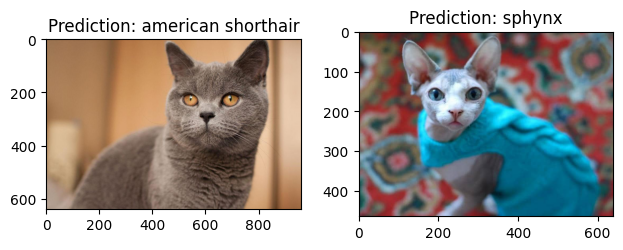

Prediction:  3    Class:  boxer
Prediction:  16    Class:  pug


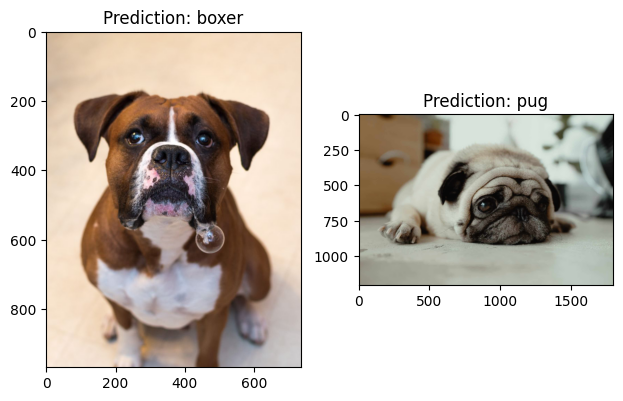

In [12]:
from PIL import Image
import glob
import matplotlib.pyplot as plt

def imshow(img, ax):
    img = Image.open(img)
    ax.imshow(img)  
    
images = []
for f in glob.iglob("/media/abdul/8266fdc5-61f6-47d6-9e82-aa0e56f4b319/Ilyas/classification/pets_classification/Pet_Breeds/test/*"):
    images.append(f)
preds = []
for i in range(0, len(images), 2):
    fig, ax = plt.subplots(1, 2)
    fig.tight_layout()
    if i < len(images):
        img = image_loader(images[i])
        pred = (model(img)).data.cpu().numpy().argmax()
        preds.append(pred)    
        print('Prediction: ', pred, '  ','Class: ', classes[pred])
        imshow(images[i], ax[0])
        ax[0].set_title('Prediction: ' + classes[pred])
    if i+1 < len(images):
        img = image_loader(images[i+1])
        pred = (model(img)).data.cpu().numpy().argmax()
        preds.append(pred)    
        print('Prediction: ', pred, '  ','Class: ', classes[pred])
        imshow(images[i+1], ax[1])
        ax[1].set_title('Prediction: ' + classes[pred])
    plt.show()
